# Load Library

In [58]:
# import system libs
import os
import pathlib
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Path Directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/PROJECT CAPSTONE/Train'
csv_dir = '/content/drive/MyDrive/PROJECT CAPSTONE/train_data.csv'

# Split Data

In [5]:
def split_data(data_dir, csv_dir):
    df = pd.read_csv(csv_dir)
    df.columns = ['filepaths', 'labels']
    df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join(data_dir, x))
    nama_penyakit = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=nama_penyakit)
    nama_penyakit = dummy_df['labels']
    validation_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=nama_penyakit)

    return train_df, validation_df, test_df

In [6]:
train_df, validation_df, test_df = split_data(data_dir, csv_dir)

# Data Generator

In [7]:
def create_generator(train_df, valid_df, test_df, batch_size, class_mode, target_size):
    #penentuan batch
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 75]))
    test_steps = ts_length // test_batch_size

    #augmentasi data
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=scalar)

    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_generator = tr_gen.flow_from_dataframe(train_df,
                                            x_col='filepaths',
                                            y_col='labels',
                                            batch_size=batch_size,
                                            class_mode=class_mode,
                                            target_size=target_size,
                                            shuffle= True)
    validation_generator = tr_gen.flow_from_dataframe(validation_df,
                                            x_col='filepaths',
                                            y_col='labels',
                                            batch_size=batch_size,
                                            class_mode=class_mode,
                                            target_size=target_size,
                                            shuffle= True)
    test_generator = ts_gen.flow_from_dataframe(test_df,
                                            x_col='filepaths',
                                            y_col='labels',
                                            batch_size=batch_size,
                                            class_mode=class_mode,
                                            target_size=target_size,
                                            shuffle= False)


    return train_generator, validation_generator, test_generator

In [8]:
train_generator, validation_generator, test_generator = create_generator(train_df, validation_df, test_df, batch_size=40,class_mode='categorical', target_size=(224, 224))

Found 6453 validated image filenames belonging to 4 classes.
Found 807 validated image filenames belonging to 4 classes.
Found 807 validated image filenames belonging to 4 classes.


# Model

In [9]:
def create_model():
  model = tf.keras.models.Sequential([
    MobileNetV3Small(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max'),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(512, kernel_regularizer=regularizers.l2(l=0.02), activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005), activation='relu'),
    Dense(215, kernel_regularizer=regularizers.l2(l=0.02), activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005), activation='relu'),
    Dropout(rate=0.35, seed=123),
    Dense(4, activation='softmax')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
                loss='categorical_crossentropy', metrics=['accuracy'])

  return model


In [10]:
model = create_model()
model.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 576)               939120    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 576)               2304      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               295424    
                                                                 
 dense_1 (Dense)             (None, 215)               110295    
                                                                 
 dropout (Dropout)           (None, 215)               0         
                                                           

In [11]:
batch_data, batch_labels = next(train_generator)
print("Shape of batch data:", batch_data.shape)
print("Shape of batch labels:", batch_labels.shape)

Shape of batch data: (40, 224, 224, 3)
Shape of batch labels: (40, 4)


# EarlyStopping

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit Model

In [14]:
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps= None,
                    shuffle= False)

Epoch 1/15
162/162 [==============================] - 1564s 10s/step - loss: 7.8512 - accuracy: 0.9190 - val_loss: 4.5174 - val_accuracy: 0.9157
Epoch 2/15
162/162 [==============================] - 377s 2s/step - loss: 2.9092 - accuracy: 0.9534 - val_loss: 1.9027 - val_accuracy: 0.9195
Epoch 3/15
162/162 [==============================] - 396s 2s/step - loss: 1.2881 - accuracy: 0.9606 - val_loss: 0.9470 - val_accuracy: 0.9517
Epoch 4/15
162/162 [==============================] - 381s 2s/step - loss: 0.6802 - accuracy: 0.9704 - val_loss: 0.6141 - val_accuracy: 0.9356
Epoch 5/15
162/162 [==============================] - 383s 2s/step - loss: 0.4450 - accuracy: 0.9695 - val_loss: 0.4544 - val_accuracy: 0.9318
Epoch 6/15
162/162 [==============================] - 380s 2s/step - loss: 0.3240 - accuracy: 0.9771 - val_loss: 0.3459 - val_accuracy: 0.9579
Epoch 7/15
162/162 [==============================] - 381s 2s/step - loss: 0.2710 - accuracy: 0.9789 - val_loss: 0.3700 - val_accuracy: 0.93

# Plot training

In [15]:
def plot_training(hist, title='Training History'):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'b', label='Training loss')
    plt.plot(Epochs, val_loss, 'm', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'b', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'm', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Set overall title
    plt.suptitle(title, fontsize=16, y=1.02)

    plt.tight_layout()
    plt.show()

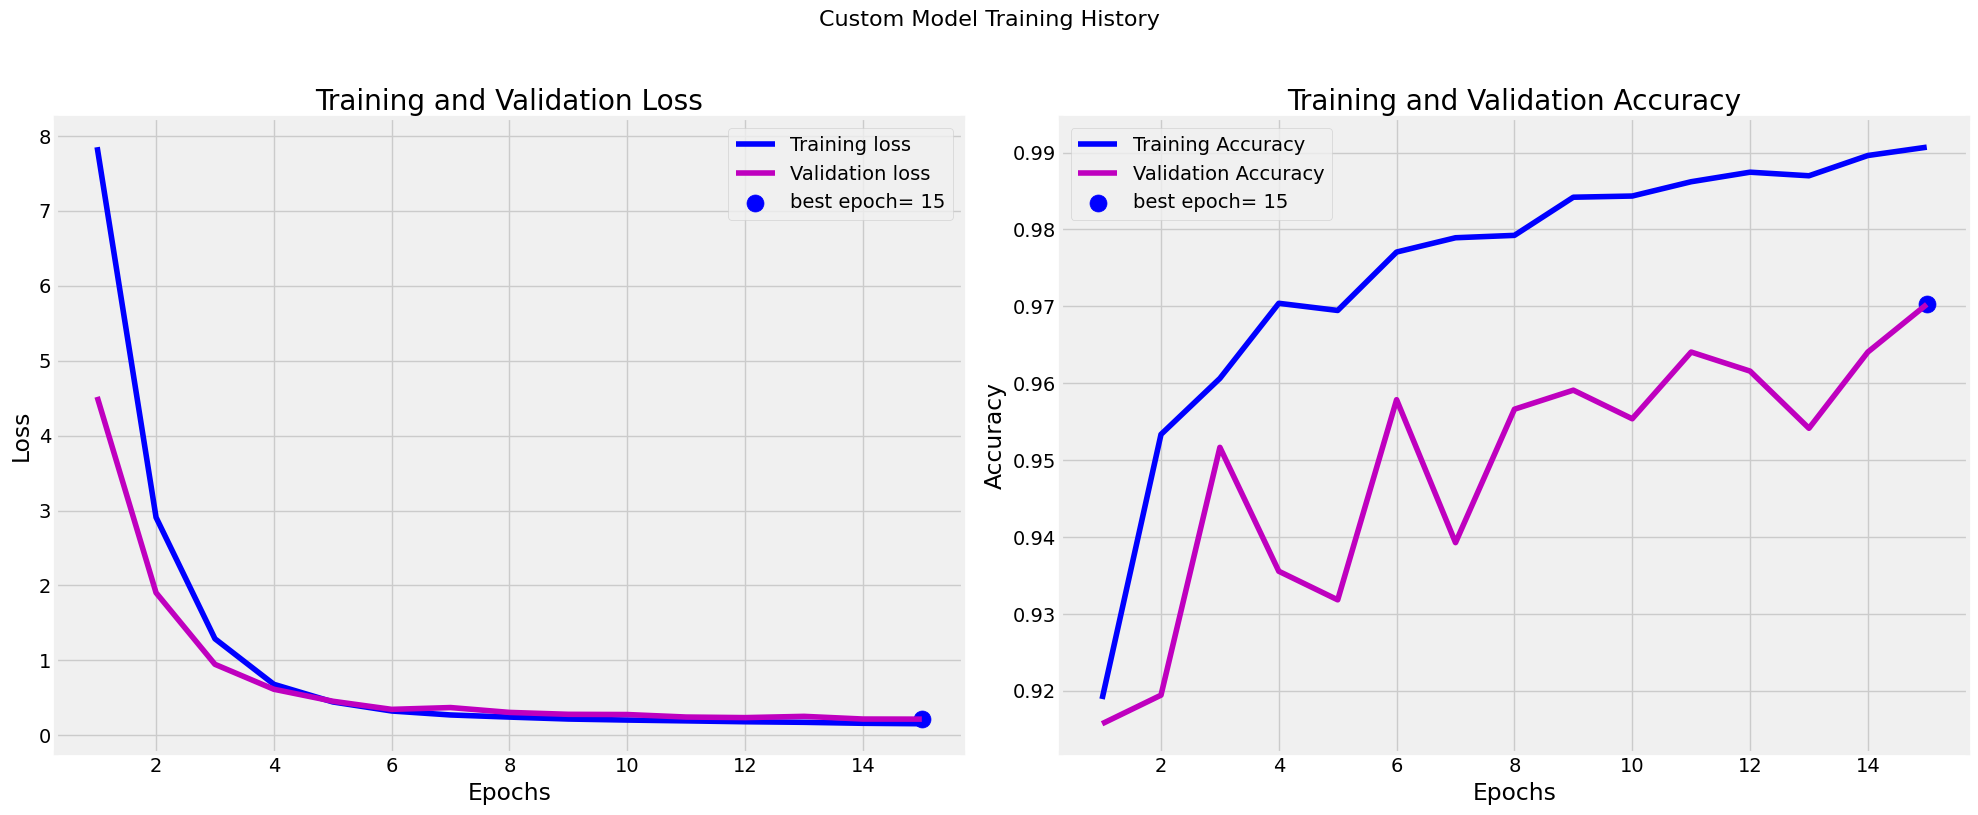

In [16]:
plot_training(history, title='Model Training History')

# Evaluasi Model

## Accuracy

In [20]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 75]))
test_steps = ts_length // test_batch_size

# Evaluate model on training data
train_score = model.evaluate(train_generator, steps=test_steps, verbose=1)
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)

# Evaluate model on validation data
valid_score = model.evaluate(validation_generator, steps=test_steps, verbose=1)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)

# Evaluate model on test data
test_score = model.evaluate(test_generator, steps=test_steps, verbose=1)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


162/269 [=================>............] - ETA: 1:52 - loss: 0.1379 - accuracy: 0.9923

269/269 [==============================] - 172s 634ms/step - loss: 0.1379 - accuracy: 0.9923
Train Loss: 0.1379
Train Accuracy: 99.23%
--------------------
 21/269 [=>............................] - ETA: 6:33 - loss: 0.2195 - accuracy: 0.9665

269/269 [==============================] - 35s 119ms/step - loss: 0.2195 - accuracy: 0.9665
Validation Loss: 0.2195
Validation Accuracy: 96.65%
--------------------
 21/269 [=>............................] - ETA: 1:48 - loss: 0.2199 - accuracy: 0.9616

269/269 [==============================] - 10s 33ms/step - loss: 0.2199 - accuracy: 0.9616
Test Loss: 0.2199
Test Accuracy: 96.16%


In [21]:
train_score = model.evaluate(train_generator, steps=len(train_generator), verbose=1)
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)

validation_score = model.evaluate(validation_generator, steps=len(validation_generator), verbose=1)
print(f"Validation Loss: {validation_score[0]:.4f}")
print(f"Validation Accuracy: {validation_score[1]*100:.2f}%")
print('-' * 20)

test_score = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

162/162 [==============================] - 175s 1s/step - loss: 0.1402 - accuracy: 0.9916
Train Loss: 0.1402
Train Accuracy: 99.16%
--------------------
21/21 [==============================] - 23s 1s/step - loss: 0.2241 - accuracy: 0.9653
Validation Loss: 0.2241
Validation Accuracy: 96.53%
--------------------
21/21 [==============================] - 9s 417ms/step - loss: 0.2199 - accuracy: 0.9616
Test Loss: 0.2199
Test Accuracy: 96.16%


## Confusion Matrix

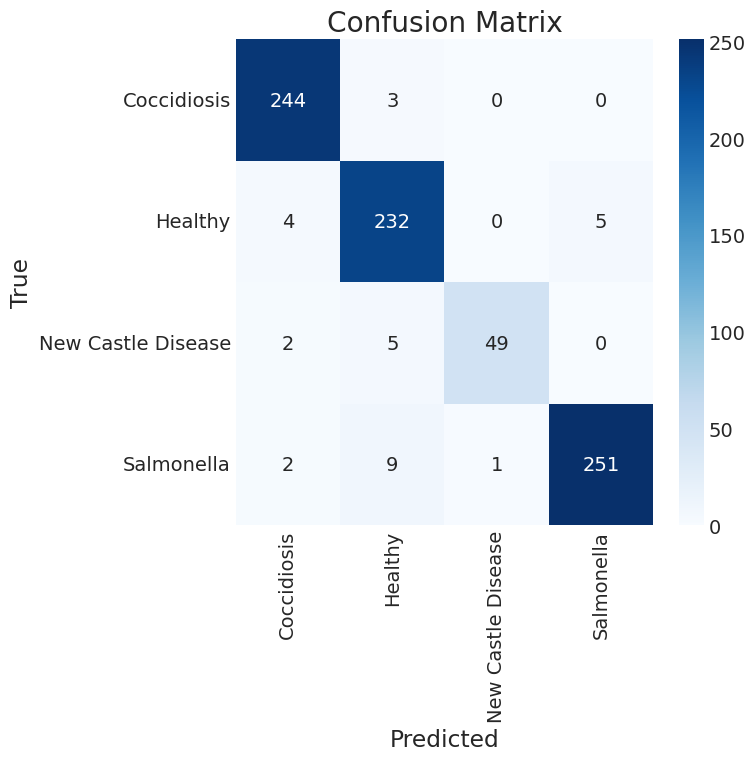

In [26]:
preds = model.predict_generator(test_generator)
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

conf_matrix = confusion_matrix(test_generator.classes, np.argmax(preds, axis=1))

# Display Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Predict

In [28]:
class_labels = train_generator.class_indices

for class_name, class_index in class_labels.items():
    print(f'Class Name: {class_name}, Class Index: {class_index}')

Class Name: Coccidiosis, Class Index: 0
Class Name: Healthy, Class Index: 1
Class Name: New Castle Disease, Class Index: 2
Class Name: Salmonella, Class Index: 3


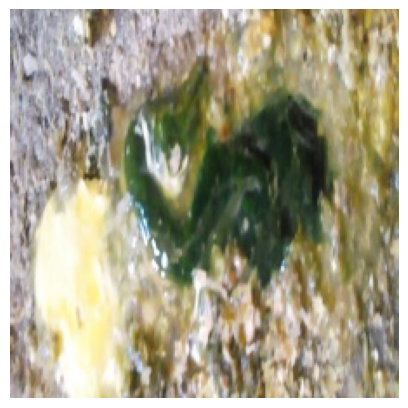

1/1 [==============================] - 0s 38ms/step
Predicted Class: New Castle Disease
Confidence Scores:
Coccidiosis: 0.0093
Healthy: 0.0108
New Castle Disease: 0.9711
Salmonella: 0.0089


In [34]:
def predict_image(model, img_path, class_labels):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])

    for class_name, class_index in class_labels.items():
        if class_index == predicted_class_index:
            print("Predicted Class:", class_name)
            break

    print("Confidence Scores:")
    for i, score in enumerate(predictions[0]):
        print(f"{list(class_labels.keys())[i]}: {score:.4f}")

img_path = "/content/drive/MyDrive/Train Capstone/ncd.343.jpg"
predict_image(model, img_path, class_labels)


# Convert model ke .tflite

In [53]:
# Mode of optimization
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.DEFAULT
else:
    optimization = tf.lite.Optimize.DEFAULT


In [54]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations =[optimization]

tflite_model = converter.convert();

In [57]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

1558392